<a href="https://colab.research.google.com/github/rwxhuang/lstm_vs_transformers/blob/main/Architecture_noise_augmentation_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Necessary Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from typing import Tuple, Union, Optional, List

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/6S898_data/"
df = pd.read_csv(DATA_PATH + "PJME_hourly.csv")
df = df.set_index('Datetime')
df.head()

Mounted at /content/drive


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [ ]:
df.index = pd.to_datetime(df.index)

# Prepare Datasets

In [ ]:
date_cutoff = df.index[int(0.75 * len(df))]
train = df.loc[df.index < date_cutoff]
test = df.loc[df.index >= date_cutoff]

sc_train = MinMaxScaler()
training_data = sc_train.fit_transform(train)

sc_test = MinMaxScaler()
test_data = sc_test.fit_transform(test)

In [ ]:
!pip install tsgm
import tsgm

aug_model = tsgm.models.augmentations.GaussianNoise()

In [ ]:
def save_jittered_dataset(variance):
  seq_length = 10

  unscaled_train = training_data.reshape((1, len(train), 1))
  aug_train = aug_model.generate(X=unscaled_train, n_samples=1, variance=variance).reshape(-1, 1)

  unscaled_test = test_data.reshape((1, len(test), 1))
  aug_test = aug_model.generate(X=unscaled_test, n_samples=1, variance=variance).reshape(-1, 1)

  np.save(os.path.join(DATA_PATH, "model-weights/aug_train_variance_" + str(variance) + ".npy"), aug_train)
  np.save(os.path.join(DATA_PATH, "model-weights/aug_test_variance_" + str(variance) + ".npy"), aug_test)


def get_dataset(variance, seq_length=10):

  aug_train = np.load(os.path.join(DATA_PATH, "model-weights/aug_train_variance_" + str(variance) + ".npy"))
  aug_test = np.load(os.path.join(DATA_PATH, "model-weights/aug_test_variance_" + str(variance) + ".npy"))

  def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

  x, y = sliding_windows(aug_train, seq_length)
  X_train, Y_train = torch.Tensor(np.array(x)), torch.Tensor(np.array(y))

  x, y = sliding_windows(aug_test, seq_length)
  X_test, Y_test = torch.Tensor(np.array(x)), torch.Tensor(np.array(y))

  return X_train, Y_train, X_test, Y_test

In [ ]:
def plot_jitter_noise(aug_train, variance):
  _train = train.iloc[0:200].reset_index()
  ax = _train[['PJME_MW']].plot(c='r',  figsize=(10,4))
  noisy_train = sc_train.inverse_transform(aug_train)
  plt.plot(noisy_train[0:200], c='b')
  plt.title("Random Gaussian Noise w/Variance=%f" % variance)
  plt.show()

In [ ]:
variances = [0.0, 0.0001, 0.001, 0.002, 0.003, 0.005, 0.008, 0.01]

In [ ]:
### ONLY RUN WHEN YOU WANT TO RE-TRAIN, WILL GIVE NEW AUGMENTED DATA
# for variance in variances:
#   save_jittered_dataset(variance)

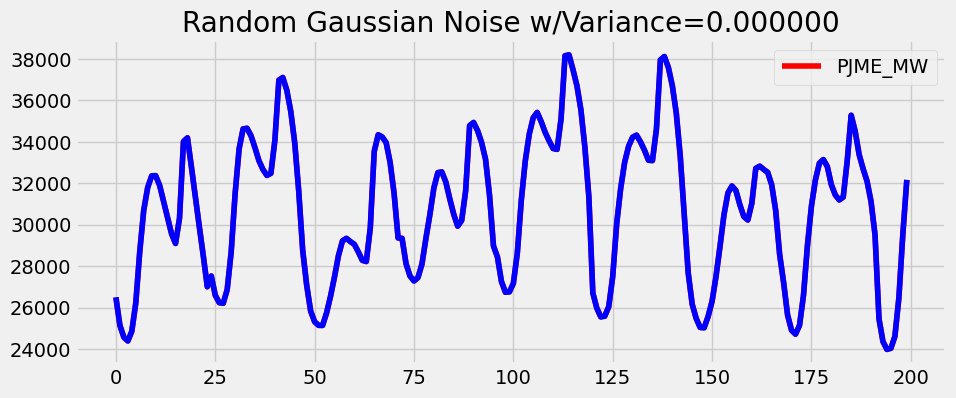

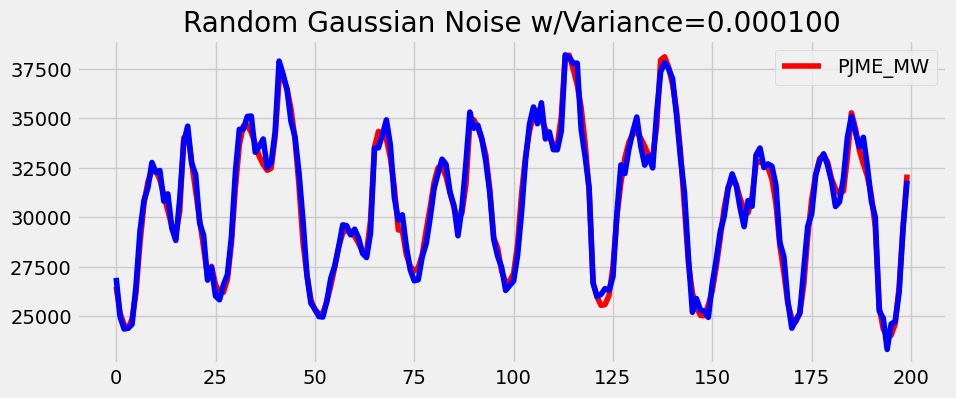

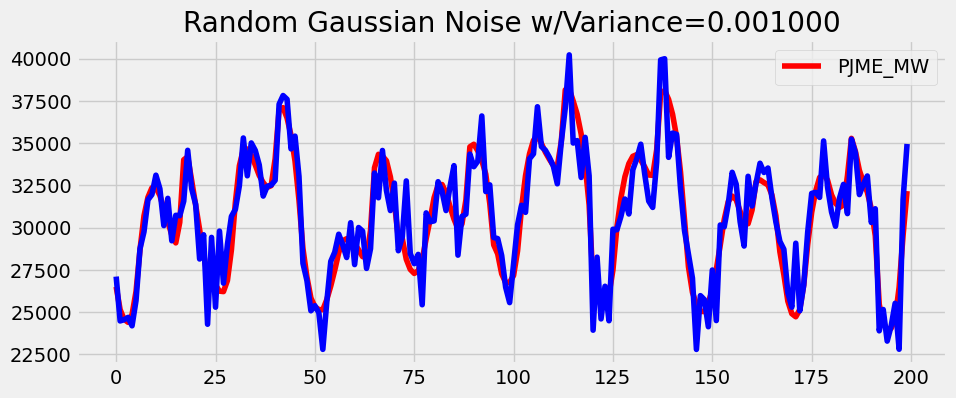

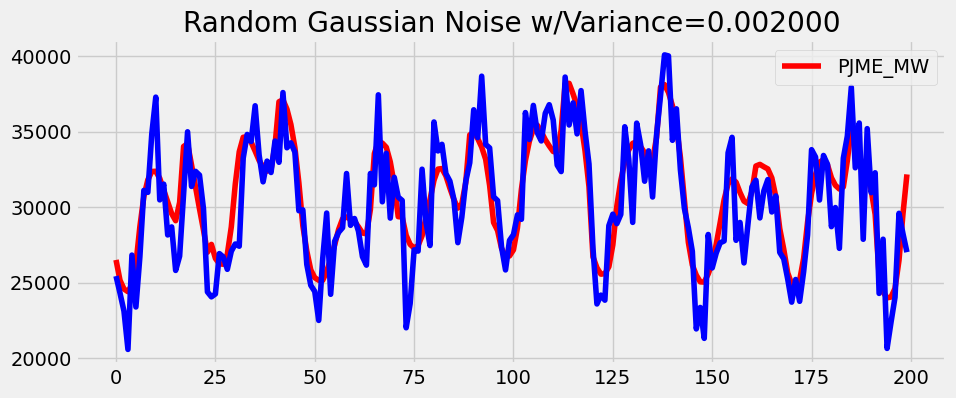

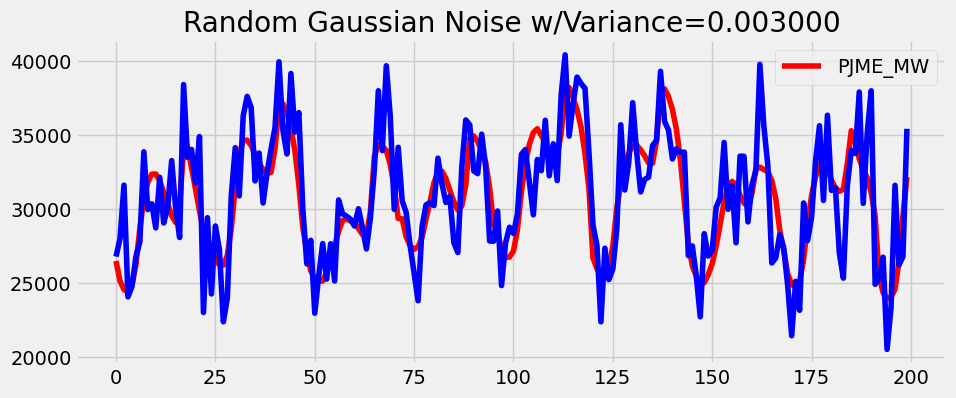

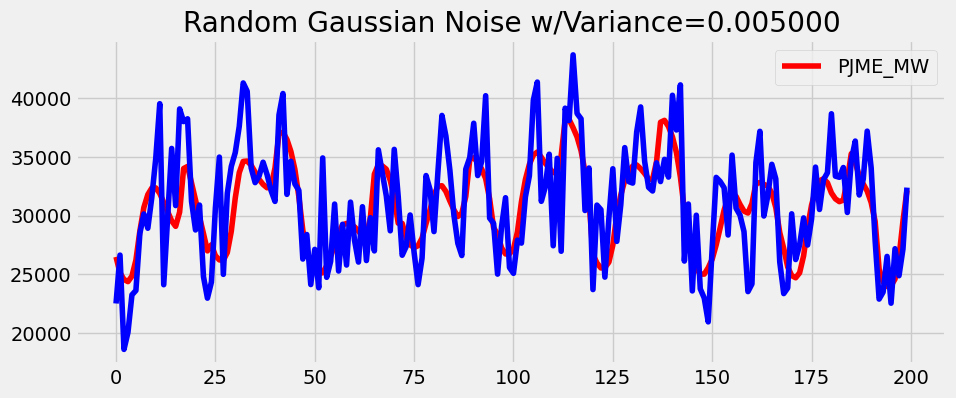

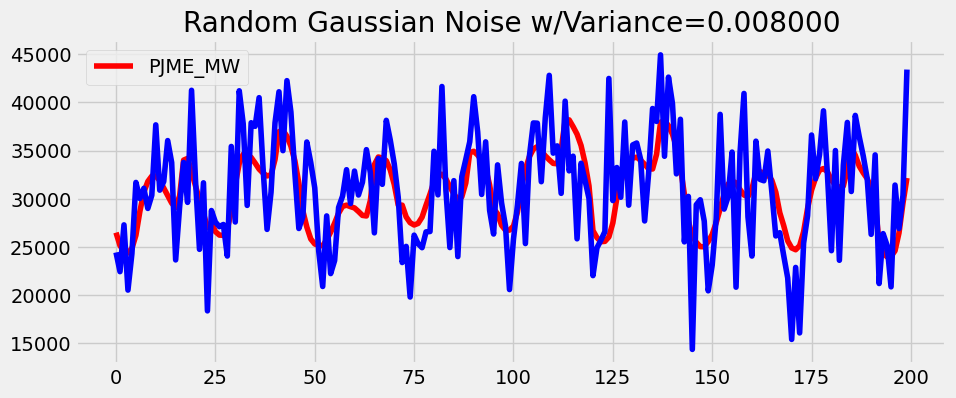

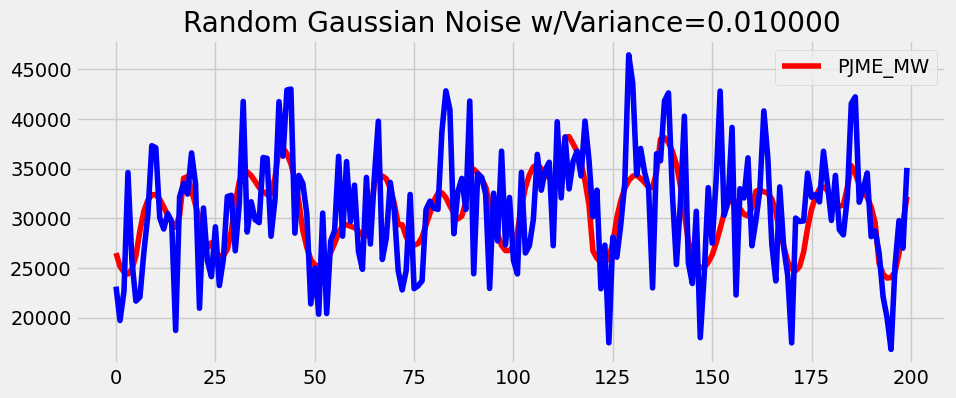

In [ ]:
for variance in variances:
  aug_train = np.load(os.path.join(DATA_PATH, "model-weights/aug_train_variance_" + str(variance) + ".npy"))
  plot_jitter_noise(aug_train, variance)
  print()


# LSTM Model

## Define the LSTM Model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length=10):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)

        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

In [ ]:
def train_model(X_train, Y_train, variance, num_epochs=500, learning_rate=0.1):
  input_size = 1
  hidden_size = 2
  num_layers = 1

  num_classes = 1

  lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

  criterion = torch.nn.MSELoss()    # mean-squared error for regression
  optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
  # optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

  # Train the model
  for epoch in range(num_epochs):
      lstm.zero_grad()
      outputs = lstm(X_train)

      # obtain the loss function
      loss = criterion(outputs, Y_train)

      loss.backward()

      optimizer.step()
      if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

  now = datetime.now()
  torch.save(lstm.state_dict(), os.path.join(DATA_PATH, 'model-weights/lstm_variance_' + str(variance) + '_weights'))

## Training

In [ ]:
for variance in variances:
  X_train, Y_train, X_test, Y_test = get_dataset(variance)
  train_model(X_train, Y_train, variance)

Epoch: 0, loss: 0.54843
Epoch: 100, loss: 0.01834
Epoch: 200, loss: 0.00105
Epoch: 300, loss: 0.00076
Epoch: 400, loss: 0.00072
Epoch: 0, loss: 0.24544
Epoch: 100, loss: 0.00315
Epoch: 200, loss: 0.00111
Epoch: 300, loss: 0.00107
Epoch: 400, loss: 0.00109
Epoch: 0, loss: 0.68499
Epoch: 100, loss: 0.00836
Epoch: 200, loss: 0.00314
Epoch: 300, loss: 0.00305
Epoch: 400, loss: 0.00301
Epoch: 0, loss: 0.22739
Epoch: 100, loss: 0.02066
Epoch: 200, loss: 0.01967
Epoch: 300, loss: 0.00472
Epoch: 400, loss: 0.00470
Epoch: 0, loss: 0.67428
Epoch: 100, loss: 0.00837
Epoch: 200, loss: 0.00630
Epoch: 300, loss: 0.00622
Epoch: 400, loss: 0.00620
Epoch: 0, loss: 0.03601
Epoch: 100, loss: 0.00883
Epoch: 200, loss: 0.00860
Epoch: 300, loss: 0.00859
Epoch: 400, loss: 0.00859
Epoch: 0, loss: 0.88295
Epoch: 100, loss: 0.01934
Epoch: 200, loss: 0.01282
Epoch: 300, loss: 0.01270
Epoch: 400, loss: 0.01314
Epoch: 0, loss: 0.64120
Epoch: 100, loss: 0.02126
Epoch: 200, loss: 0.01691
Epoch: 300, loss: 0.01573
Ep

# Evaluation

In [ ]:
def plot_result(res, test_set, variance):
  # _test = test_set.iloc[0:200].reset_index()
  # ax = _test[['PJME_MW']].plot(c='r',  figsize=(10,4))
  noisy_test = sc_train.inverse_transform(test_set)
  plt.plot(noisy_test[0:200], c='r')
  noisy_res = sc_train.inverse_transform(res)
  plt.plot(noisy_res[0:200], c='b')
  plt.title("Test w/Variance=%f" % variance)
  plt.show()

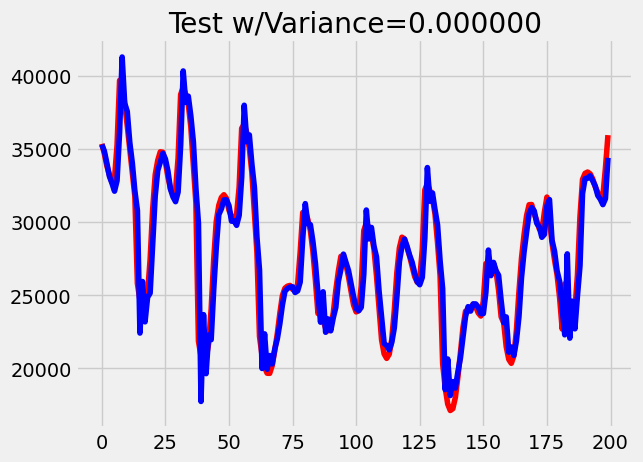

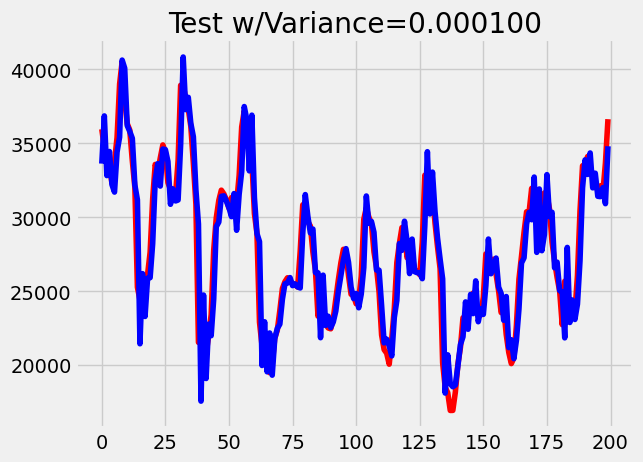

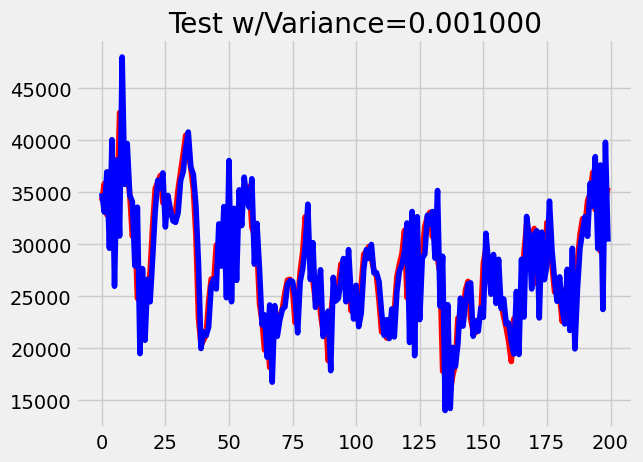

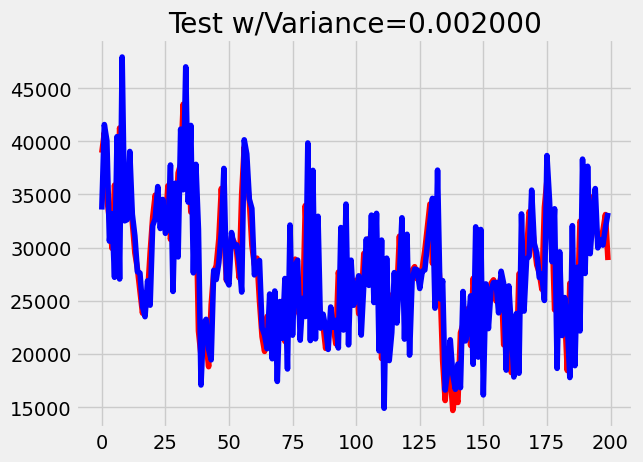

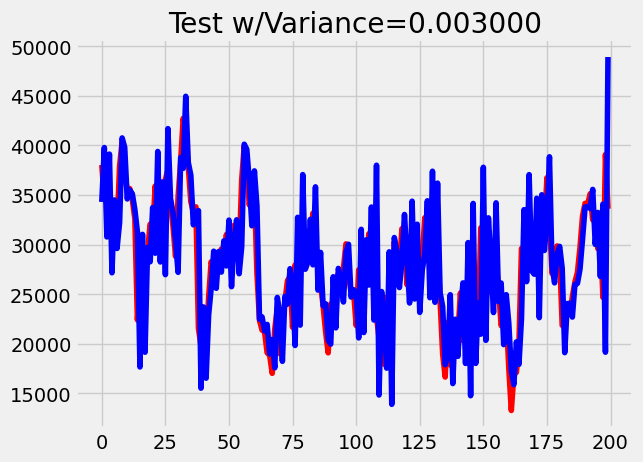

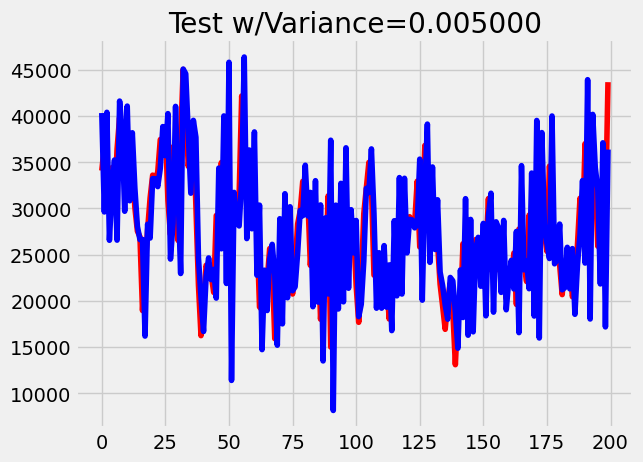

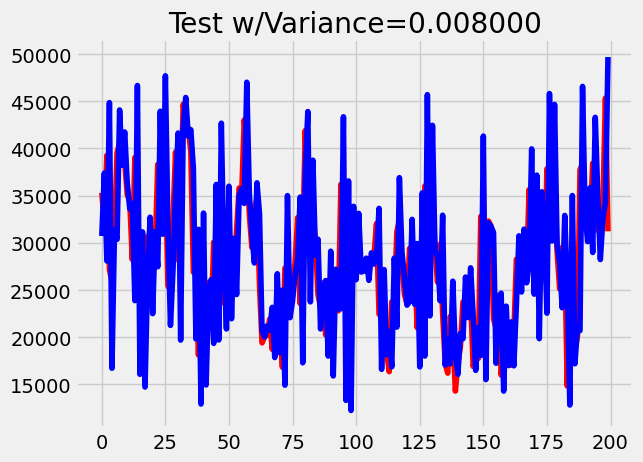

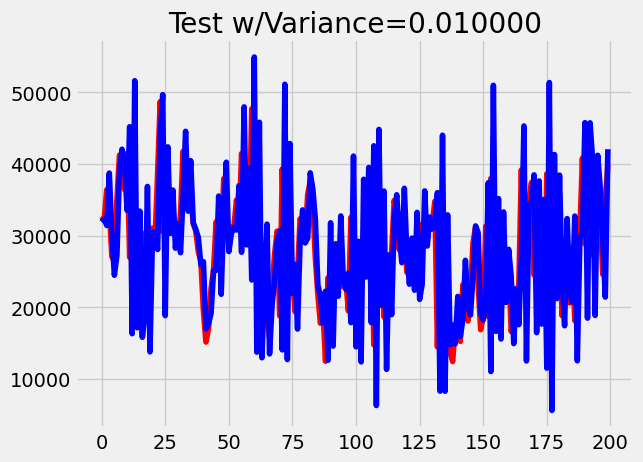

In [ ]:
#Load model from drive
input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
losses = []

for variance in variances:
  X_train, Y_train, X_test, Y_test = get_dataset(variance)
  lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
  state_dict = torch.load(DATA_PATH + 'model-weights/lstm_variance_' + str(0.0) + '_weights')
  lstm.load_state_dict(state_dict)
  lstm.eval()
  with torch.no_grad():
    out = lstm(X_test)
    plot_result(out, Y_test, variance)
    losses.append(torch.nn.MSELoss()(out, Y_test).item())
  # print(train_predict[:10], Y_train[:10])

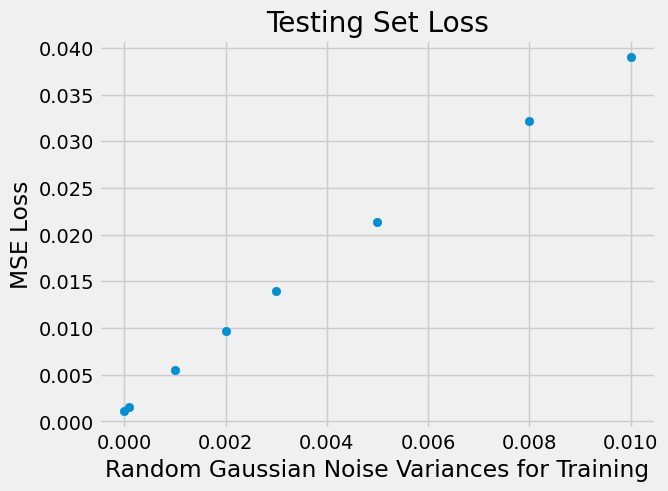

In [ ]:
plt.xlabel('Random Gaussian Noise Variances for Training')
plt.ylabel('MSE Loss')
plt.title('Testing Set Loss')
plt.scatter(variances, losses)

# Transformer Model

# Define Transformer Model

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = X_train.shape[1:]

for variance in variances:
  X_train, Y_train, X_test, Y_test = get_dataset(variance)
  model = build_model(
      input_shape,
      head_size=256,
      num_heads=4,
      ff_dim=4,
      num_transformer_blocks=4,
      mlp_units=[128],
      mlp_dropout=0.4,
      dropout=0.25,
  )

  model.compile(
      loss="mean_squared_error",
      optimizer=keras.optimizers.Adam(learning_rate=1e-4)
  )
  #model.summary()

  callbacks = [keras.callbacks.EarlyStopping(patience=10, \
      restore_best_weights=True)]

  model.fit(
      X_train.numpy(),
      Y_train.numpy(),
      validation_split=0.2,
      epochs=10,
      batch_size=64,
      callbacks=callbacks,
  )

  model.save(os.path.join(DATA_PATH, 'model-weights/transformer_variance_' + str(variance) + '_weights'), save_format="h5")

Epoch 1/10
1376/1376 [==============================] - 156s 109ms/step - loss: 0.0371 - val_loss: 0.0034
Epoch 2/10
1376/1376 [==============================] - 145s 106ms/step - loss: 0.0056 - val_loss: 0.0013
Epoch 3/10
1376/1376 [==============================] - 147s 107ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 4/10
1376/1376 [==============================] - 144s 105ms/step - loss: 0.0025 - val_loss: 7.5075e-04
Epoch 5/10
1376/1376 [==============================] - 145s 106ms/step - loss: 0.0019 - val_loss: 6.3367e-04
Epoch 6/10
1376/1376 [==============================] - 148s 107ms/step - loss: 0.0015 - val_loss: 5.4596e-04
Epoch 7/10
1376/1376 [==============================] - 146s 106ms/step - loss: 0.0012 - val_loss: 5.1126e-04
Epoch 8/10
1376/1376 [==============================] - 148s 107ms/step - loss: 0.0011 - val_loss: 4.8668e-04
Epoch 9/10
1376/1376 [==============================] - 146s 106ms/step - loss: 9.3185e-04 - val_loss: 4.7321e-04
Epoch 10/10
1376/1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
1376/1376 [==============================] - 152s 106ms/step - loss: 0.0336 - val_loss: 0.0030
Epoch 2/10
1376/1376 [==============================] - 145s 105ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 3/10
1376/1376 [==============================] - 146s 106ms/step - loss: 0.0031 - val_loss: 9.9801e-04
Epoch 4/10
1376/1376 [==============================] - 143s 104ms/step - loss: 0.0025 - val_loss: 9.0907e-04
Epoch 5/10
1376/1376 [==============================] - 142s 103ms/step - loss: 0.0020 - val_loss: 8.2357e-04
Epoch 6/10
1376/1376 [==============================] - 143s 104ms/step - loss: 0.0017 - val_loss: 7.7589e-04
Epoch 7/10
1376/1376 [==============================] - 143s 104ms/step - loss: 0.0015 - val_loss: 7.7643e-04
Epoch 8/10
1376/1376 [==============================] - 142s 103ms/step - loss: 0.0013 - val_loss: 7.7379e-04
Epoch 9/10
1376/1376 [==============================] - 142s 103ms/step - loss: 0.0012 - val_loss: 7.3668e-04
Epoch 10/10
1376/1

## Evaluation

1103/1103 [==============================] - 41s 37ms/step


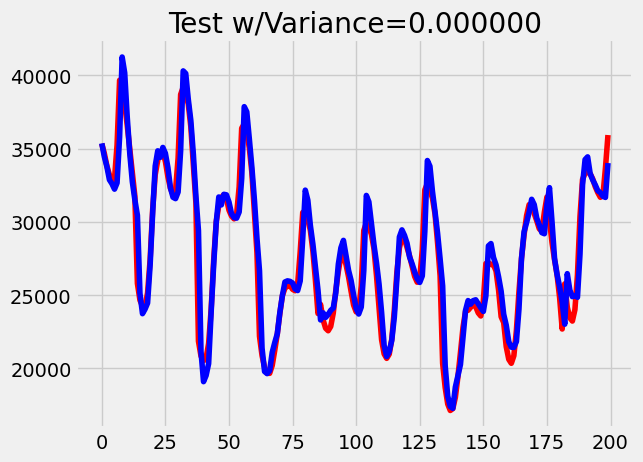

1103/1103 [==============================] - 43s 38ms/step


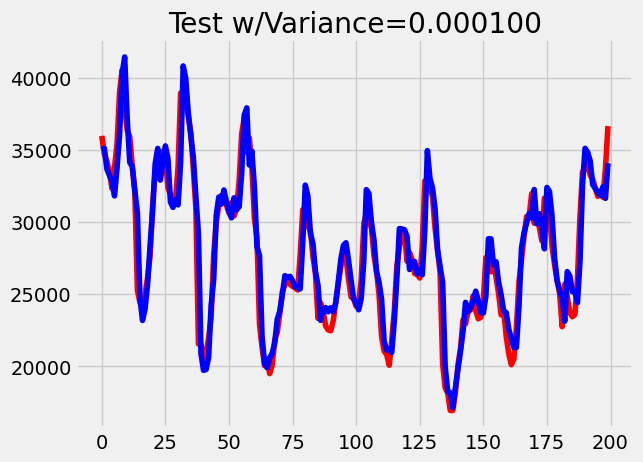

1103/1103 [==============================] - 40s 36ms/step


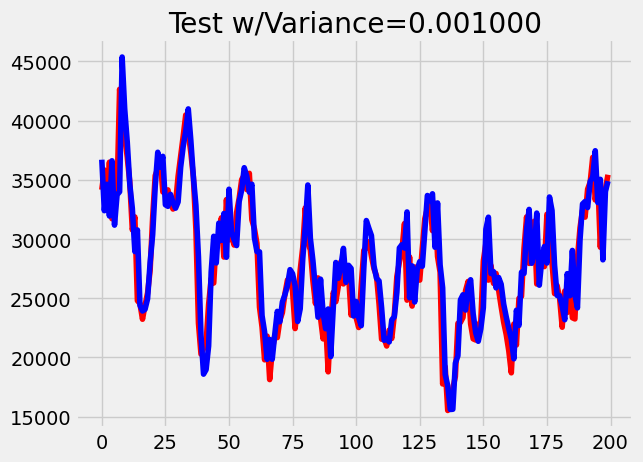

1103/1103 [==============================] - 40s 36ms/step


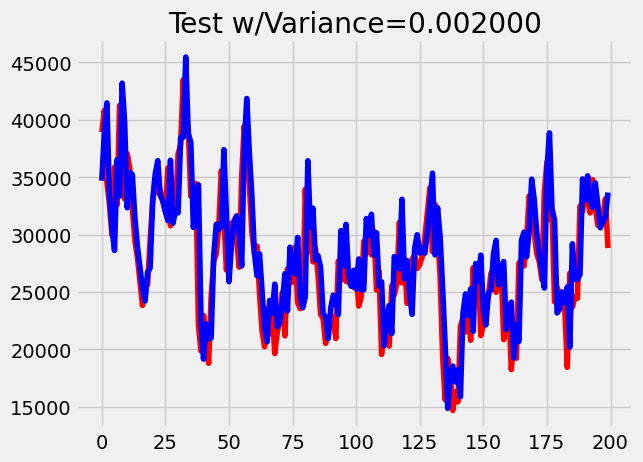

1103/1103 [==============================] - 41s 36ms/step


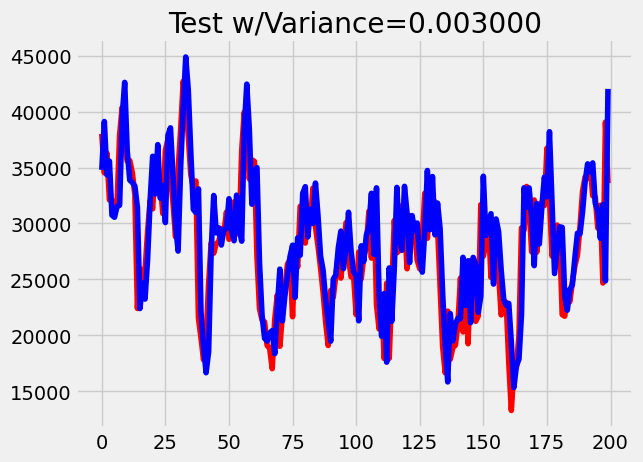

1103/1103 [==============================] - 42s 38ms/step


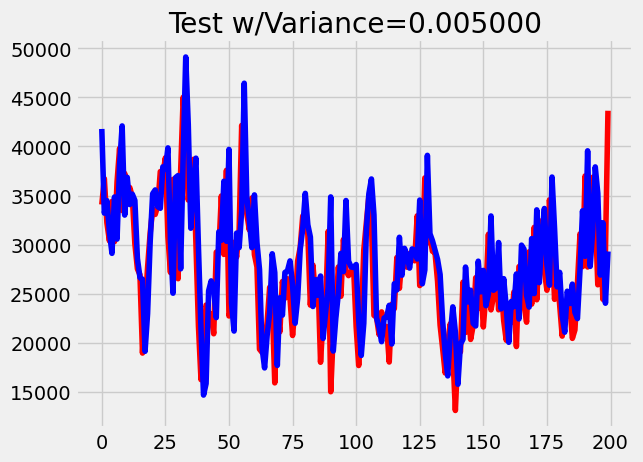

1103/1103 [==============================] - 42s 38ms/step


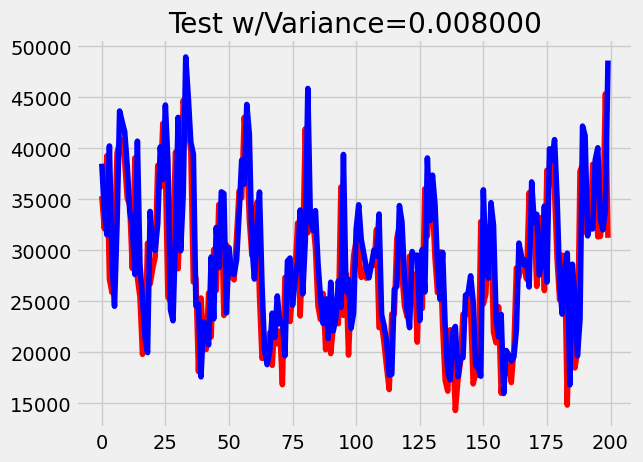

1103/1103 [==============================] - 41s 37ms/step


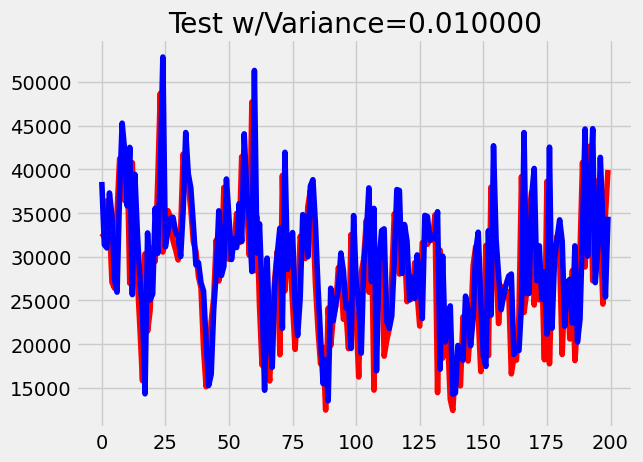

1103/1103 [==============================] - 42s 37ms/step - loss: 0.0236


[0.00079802778782323,
 0.001048679114319384,
 0.0032470058649778366,
 0.005626230034977198,
 0.007990218698978424,
 0.012503386475145817,
 0.019166374579072,
 0.02355790324509144]

In [ ]:
import tensorflow as tf
res = []
for variance in variances:
  X_train, Y_train, X_test, Y_test = get_dataset(variance)
  model = tf.keras.models.load_model(DATA_PATH + 'model-weights/transformer_variance_' + str(0.0) + '_weights')
  out = model.predict(X_test.numpy())
  plot_result(out, Y_test, variance)
  res.append(model.evaluate(X_test.numpy(), Y_test.numpy()))
res

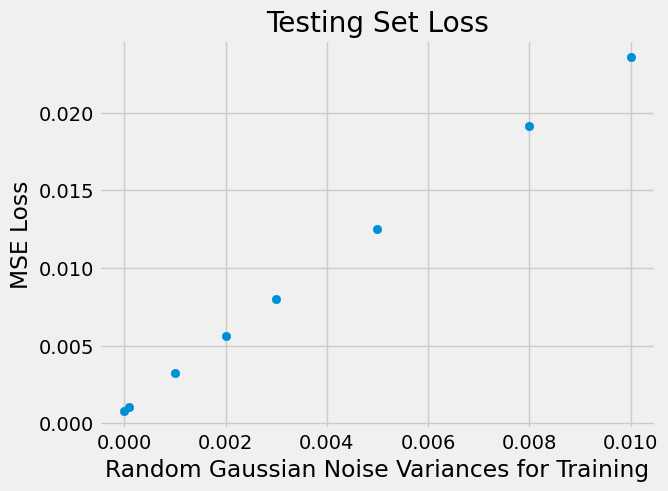

In [ ]:
plt.xlabel('Random Gaussian Noise Variances for Training')
plt.ylabel('MSE Loss')
plt.title('Testing Set Loss')
plt.scatter(variances, res)

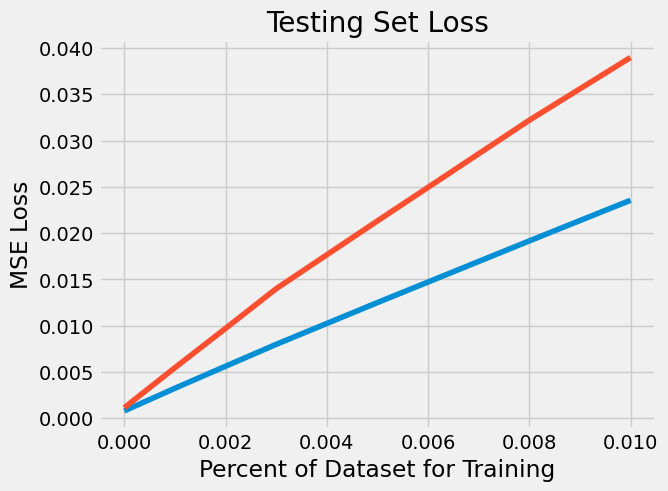

In [ ]:
plt.xlabel('Percent of Dataset for Training')
plt.ylabel('MSE Loss')
plt.title('Testing Set Loss')
plt.plot(variances, res)
plt.plot(variances, losses)